# Naive Bayes

## Lectura de datos

In [1]:
import pandas as pd
import nltk
import gensim
import sqlite3

sqlite_db = "../dataset/fake_news.sqlite"

conn = sqlite3.connect(sqlite_db)
df = pd.read_sql_query("SELECT * FROM NEWS", conn)
conn.close()

## Total de palabras en el dataset

In [2]:
list_of_words = []
unique_words = set()
for document in df.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844932 unique_words:96134


## División de los datos

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [4]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_seq, maxlen = 40, padding = 'post', truncating = 'post')
x_test_padded = pad_sequences(x_test_seq, maxlen = 40, truncating = 'post') 

In [6]:
print(x_train_seq[0])

[2176, 1362, 1, 392, 43, 3098, 11, 144, 223, 3, 1362, 2, 12, 1, 141, 270, 1837, 305, 691, 195, 291, 15, 279, 168, 43, 21, 31, 69, 467, 3432, 384, 141, 43, 25, 812, 63, 118, 662, 63, 42, 766, 5736, 223, 3, 144, 87, 9834, 6975, 339, 69, 308, 21, 31, 288, 1, 205, 89, 117, 1113, 1837, 4, 143, 355, 1095, 2410, 1858, 167, 1041, 2162, 360, 1485, 60, 4115, 5584, 2466, 392, 1774, 763, 492, 8382, 7417, 16984, 3055, 691, 15, 1123, 198, 4516, 223, 3, 149, 79, 612, 7036, 781, 167, 355, 1903, 105, 1, 40792, 230, 40, 3099, 7418, 208, 1229, 254, 223, 3, 306, 1, 423, 536, 63, 133, 1041, 355, 167, 411, 35017, 22, 718, 17546, 222, 223, 3, 144, 7888, 55337, 150, 57, 1297, 1339, 339, 9834, 16504, 1614, 1614, 222, 713, 1, 71, 187, 755, 386, 2049, 1117, 2217, 7223, 1134, 299, 519, 54, 713, 713, 982, 3927, 40793, 1, 627, 635, 603, 2667, 667, 42, 10, 2052, 423, 1, 15, 2, 4, 236, 71, 2742, 15, 7939, 1, 176, 42, 1028, 40793, 150, 87, 1614, 713, 127, 503, 16504, 1339, 1339, 1297, 467, 87, 314, 229, 223, 3, 144, 1

In [7]:
print(x_train_padded[0])

[2176 1362    1  392   43 3098   11  144  223    3 1362    2   12    1
  141  270 1837  305  691  195  291   15  279  168   43   21   31   69
  467 3432  384  141   43   25  812   63  118  662   63   42]


In [8]:
import numpy as np
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))

In [9]:
x_train_padded

array([[ 2176,  1362,     1, ...,   662,    63,    42],
       [  858,  1745,   118, ...,   131,    59,   436],
       [    1,   296,  1082, ...,   649,  3977, 10906],
       ...,
       [    1,   514, 47168, ...,   599,    34,    87],
       [    9,    66,   672, ...,  1298,  2911,    37],
       [   13,   220,   911, ...,    29,  2658,   911]], dtype=int32)

## Construcción del modelo

In [17]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
%time clf.fit(x_train_padded, y_train)

CPU times: user 21.6 ms, sys: 1.93 ms, total: 23.5 ms
Wall time: 22.9 ms


/home/drojas/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [21]:
prediction = clf.predict(x_test_padded)

In [22]:
prediction_list = []
for i in range(len(prediction)):
    if prediction[i].item() > 0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction_list)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.5887725551347739


[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

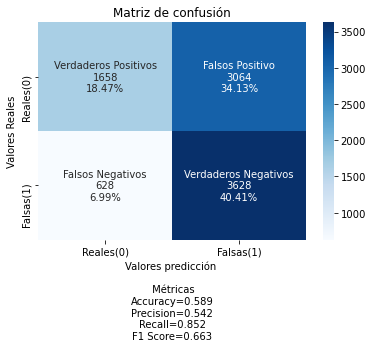

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(list(y_test), prediction_list, labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm[1,1] / sum(cm[:,1])
recall    = cm[1,1] / sum(cm[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])